In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [ ]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nuclease_design import amino_acids
from nuclease_design import constants
from nuclease_design import plotting
from nuclease_design import utils


# Load data

In [ ]:
DATA_DIR = constants.DATA_DIR

In [ ]:
df = utils.load_all_data(DATA_DIR)
expand_df = utils.expand_sublibraries(df)

In [ ]:
landscape_df = utils.load_landscape(DATA_DIR)

In [ ]:
def get_landscape_up_to_generation(landscape_df, generations):
  new_df = landscape_df[
      landscape_df['generations'].apply(
          lambda x: any(generation in x for generation in generations)
      )
  ]
  return new_df


def remove_controls(df, non_control_sublibrary_names):
  new_df = df[
      df['sublibrary_names'].apply(
          lambda x: any(
              sublibrary_name in x
              for sublibrary_name in non_control_sublibrary_names
          )
      )
  ]
  print('removed: ', df.shape[0] - new_df.shape[0])
  return new_df

In [ ]:
non_controls_g3 = [
    'g3_prosar_high_screen_low',
    'g3_prosar_high_screen_high',
    'g3_prosar_low_screen_high',
    'g3_prosar_low_screen_low',
    'g3_prosar_low_unscreened',
    'g3_mbo_dnn_exploit',
    'g3_mbo_dnn_explore',
    'g3_unmatched',
]

non_controls_g4 = [
    'g4_other',
    'g4_unmatched',
    'g4_mbo_dnn',
    'g4_mbo_linear',
    'g4_sample_and_screen_dnn',
    'g4_sample_and_screen_linear',
    'g4_sample_unscreened',
]

In [ ]:
def add_activity_level_columns(landscape_df):
  df = landscape_df.copy()
  for ref, activity_level in zip(['neg_control', 'wt', 'a73r'], ['activity_greater_than_0', 'activity_greater_than_WT',  'activity_greater_than_A73R']):
    df[f'activity_greater_than_{ref}'] = df['activity_level'] == activity_level
  return df

In [ ]:
landscape_df = add_activity_level_columns(landscape_df)

In [ ]:
up_to_g1_df = get_landscape_up_to_generation(landscape_df, {'g1'}).copy()
g2_redux_df = expand_df[expand_df['sublibrary_name'] == 'prosar+screen_g2_redux']

up_to_g2_df = get_landscape_up_to_generation(landscape_df, {'g1', 'g2'}).copy()
non_controls_g3_df = remove_controls(df[df['generation'] == 'g3'], non_controls_g3)

up_to_g3_df = get_landscape_up_to_generation(landscape_df, {'g1', 'g2', 'g3'}).copy()
non_controls_g4_df = remove_controls(df[df['generation'] == 'g4'], non_controls_g4)

removed:  3764
removed:  4467


In [ ]:
name_to_plot_kwargs = {
    'g1': {'train_df': up_to_g1_df, 'design_df': g2_redux_df, 'activity_level': 'wt'},
    'g2': {'train_df': up_to_g2_df, 'design_df': non_controls_g3_df, 'activity_level': 'wt'},
    'g3': {'train_df': up_to_g3_df, 'design_df': non_controls_g4_df, 'activity_level': 'wt'},
}

In [ ]:
up_to_g2_df.columns

Index(['mutations', 'num_mutations', 'sublibrary_names', 'generations',
       'activity_level', 'is_functional', 'sequence',
       'activity_greater_than_neg_control', 'activity_greater_than_wt',
       'activity_greater_than_a73r'],
      dtype='object')

In [ ]:
up_to_g1_df['activity_level'].value_counts()

non-functional              8456
activity_greater_than_0      875
activity_greater_than_WT     110
Name: activity_level, dtype: int64

In [ ]:
def make_hits_histplot(train_df, design_df, activity_level, ax=None):
  train_df = train_df.copy()
  design_df = design_df.copy()
  if activity_level not in {'neg_control', 'wt', 'a73r'}:
    raise ValueError(f'{activity_level} not in [neg_control, wt, a73r]')

  train_hits_df = train_df[
      train_df[f'activity_greater_than_{activity_level}']
  ].copy()
  train_hits_df['set'] = 'training set hits'
  design_hits_df = design_df[
      design_df[f'activity_greater_than_{activity_level}']
  ].copy()
  design_hits_df['set'] = 'designed hits'
  plotdf = pd.concat([train_hits_df, design_hits_df], ignore_index=True)
  ax.legend(bbox_to_anchor=(1.05, 1))
  sns.histplot(
      data=plotdf,
      x='num_mutations',
      hue='set',
      multiple='layer',
      discrete=True,
      ax=ax,
  )

<ipython-input-78-080ab15676d4>:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  plotdf = pd.concat([train_hits_df, design_hits_df], ignore_index=True)
<ipython-input-78-080ab15676d4>:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  plotdf = pd.concat([train_hits_df, design_hits_df], ignore_index=True)
<ipython-input-78-080ab15676d4>:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  plotdf = pd.concat([train_hits_df, design_hits_df], ignore_index=True)


Text(0.5, 0, 'Number of Mutations')

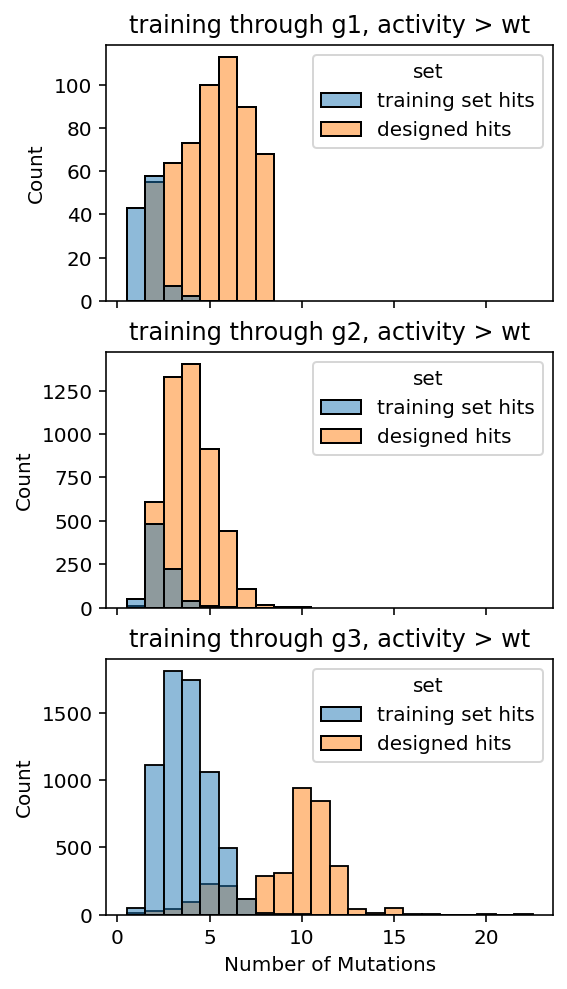

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(4, 8))
for i, (name, kwargs) in enumerate(name_to_plot_kwargs.items()):
  ax = axs[i]
  make_hits_histplot(ax=ax, **kwargs)
  activity_level = kwargs['activity_level']
  ax.set_title(f'training through {name}, activity > {activity_level}')
plt.xlabel('Number of Mutations')

# Novelty analysis

In [ ]:
def get_novel_mutations(train_df, design_df, activity_level):
  activity_column = f'activity_greater_than_{activity_level}'
  unique_design_mutations = (
      design_df[design_df[activity_column]].mutations.explode().unique()
  )
  unique_train_mutations = (
      train_df[train_df[activity_column]].mutations.explode().unique()
  )
  return pd.Series(unique_design_mutations)[
      ~pd.Series(unique_design_mutations).isin(unique_train_mutations)
  ].values

In [ ]:
def get_unique_mutations(df, activity_level):
  df = df[df['num_mutations'] > 0].copy()
  activity_column = f'activity_greater_than_{activity_level}'
  return df[df[activity_column]].mutations.explode().unique()

In [ ]:
def make_mutation_heatmap_comparison(
    mutations_a,
    mutations_b,
    color_a,
    color_b,
    inclusive_one_indexed_position_start,
    exclusive_one_indexed_position_end,
    ax,
    parent_sequence=constants.FULL_REFERENCE_SEQ,
):
  aa_sorted = sorted(
      amino_acids.AA, key=amino_acids.AA_TO_ISOELECTRIC_POINT.get, reverse=True
  )
  aa_to_index = {aa: i for i, aa in enumerate(aa_sorted)}

  positions = list(
      range(
          inclusive_one_indexed_position_start,
          exclusive_one_indexed_position_end,
      )
  )

  val_a = 1
  val_b = 2
  # parent_val = 3
  counts = np.zeros(shape=(max(positions) + 1, len(amino_acids.AA)))
  for mutations, val in zip((mutations_a, mutations_b), (val_a, val_b)):
    plotting._add_mutations_to_count_matrix(counts, mutations, val, aa_to_index)

  parent_plot_indexes = []
  for one_indexed_position in range(
      inclusive_one_indexed_position_start, exclusive_one_indexed_position_end
  ):
    parent_aa = parent_sequence[one_indexed_position - 1]
    parent_plot_indexes.append((one_indexed_position, aa_to_index[parent_aa]))

  df = pd.DataFrame(counts.T, index=aa_to_index.keys())

  light_color = sns.light_palette(color_a)[0]
  cmap = sns.color_palette(
      [light_color, color_a, color_b], as_cmap=True
  )

  sns.heatmap(
      data=df,
      ax=ax,
      xticklabels=5,
      yticklabels=True,
      linewidths=0.1,
      cbar=False,
      cmap=cmap,
  )
  ax.set(xlabel='', ylabel='')

  xs = [index[0] + 0.5 for index in parent_plot_indexes]
  ys = [index[1] + 0.5 for index in parent_plot_indexes]
  ax.plot(xs, ys, marker='.', color=plotting.WT_COLOR, linestyle='None')

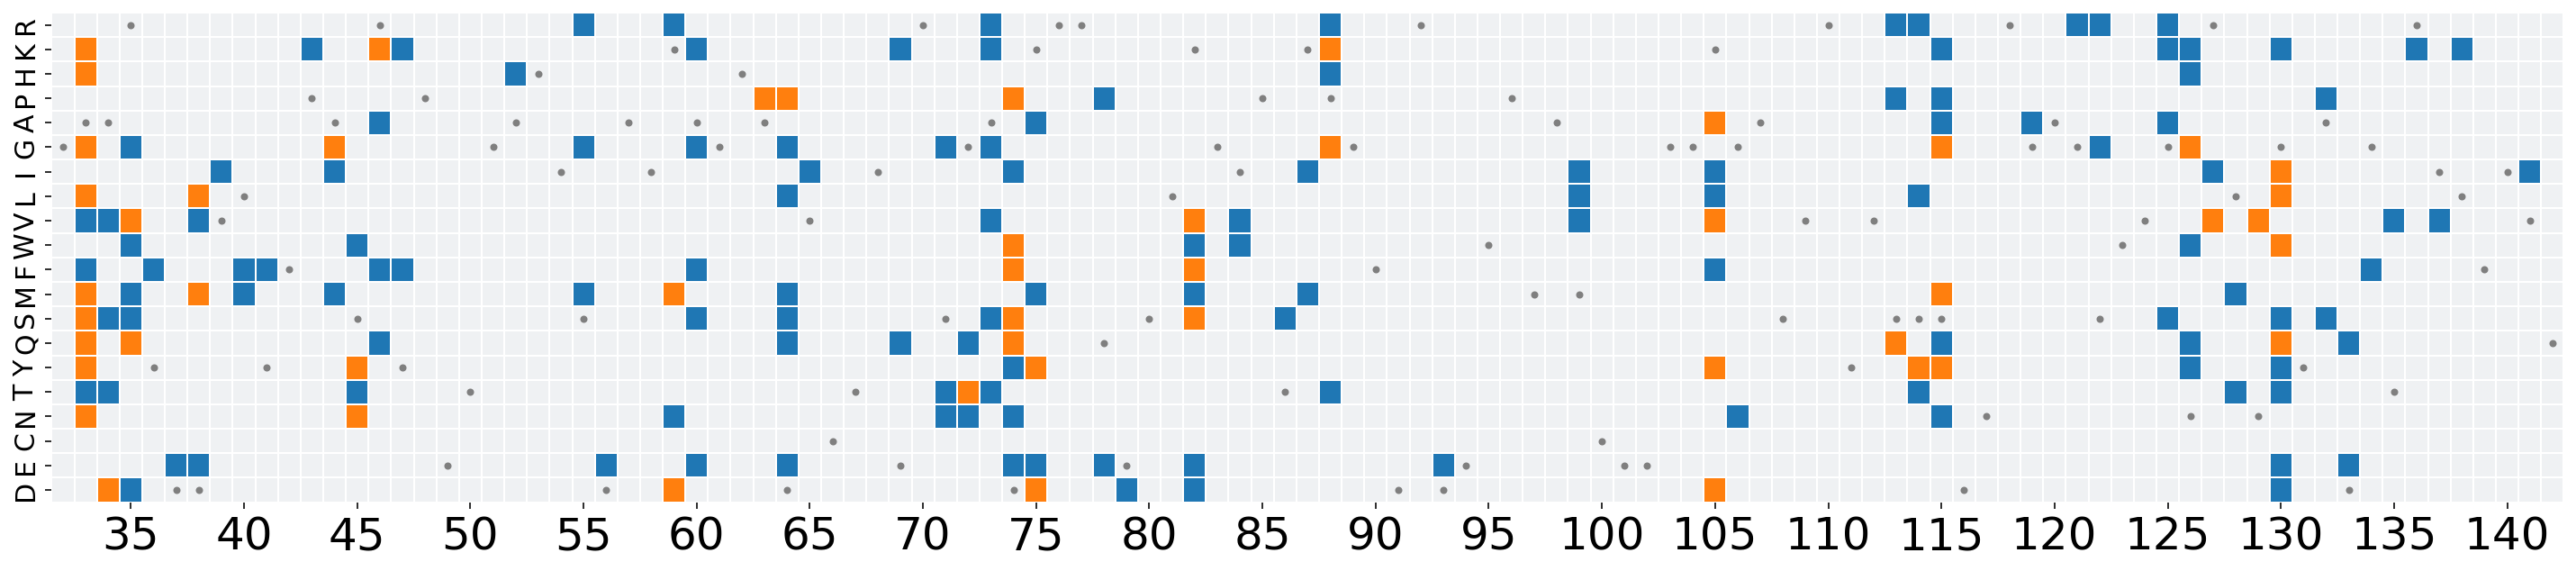

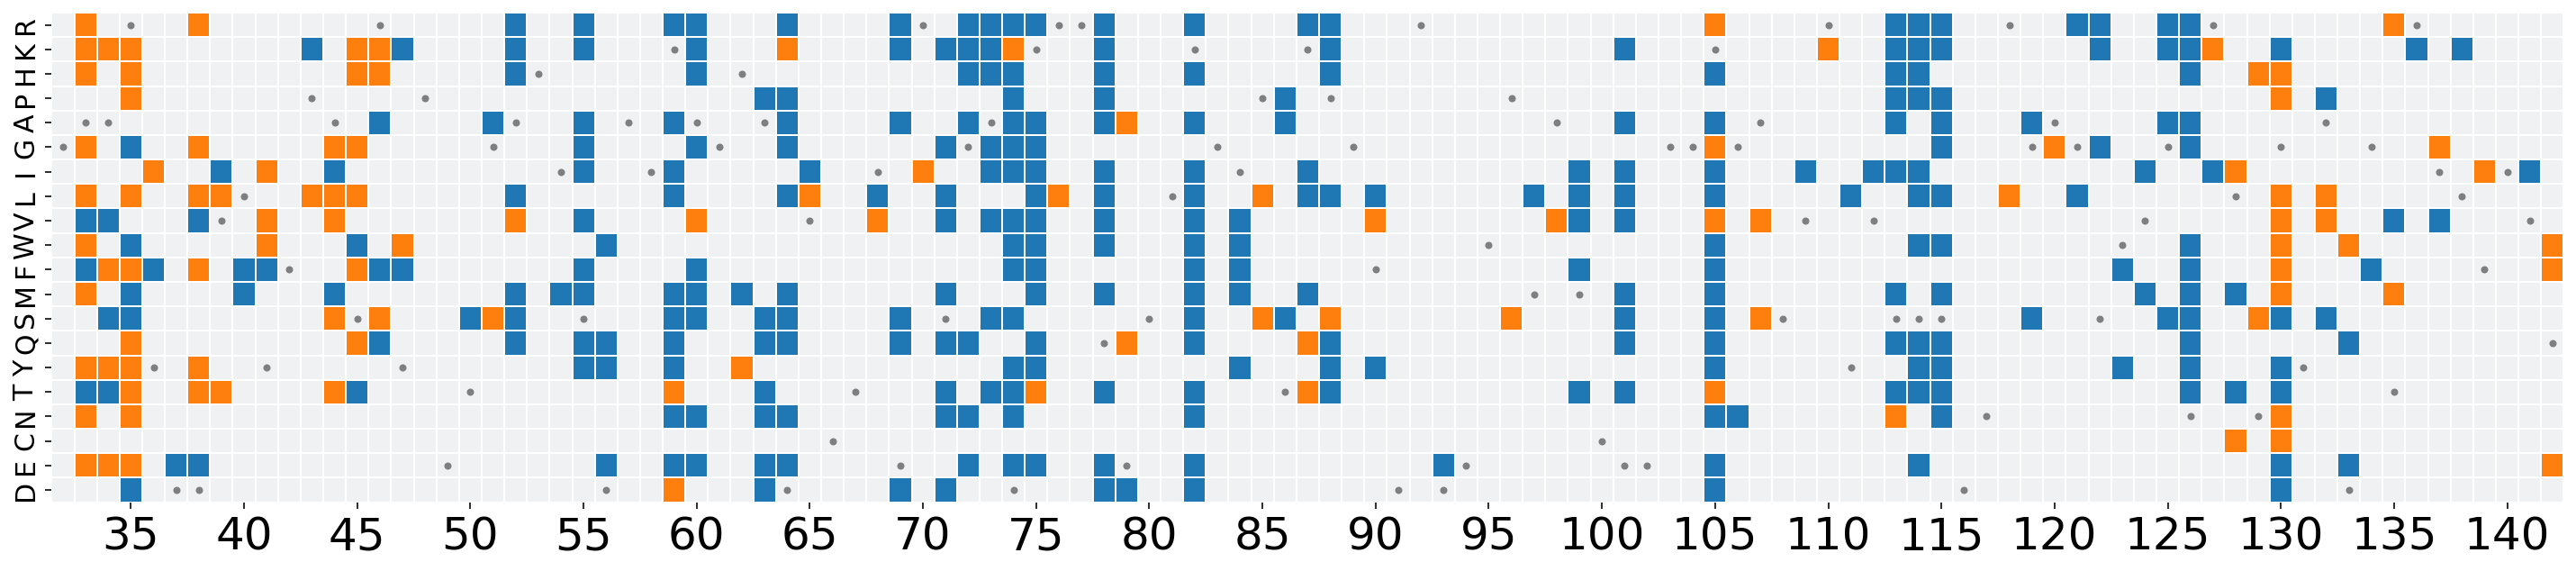

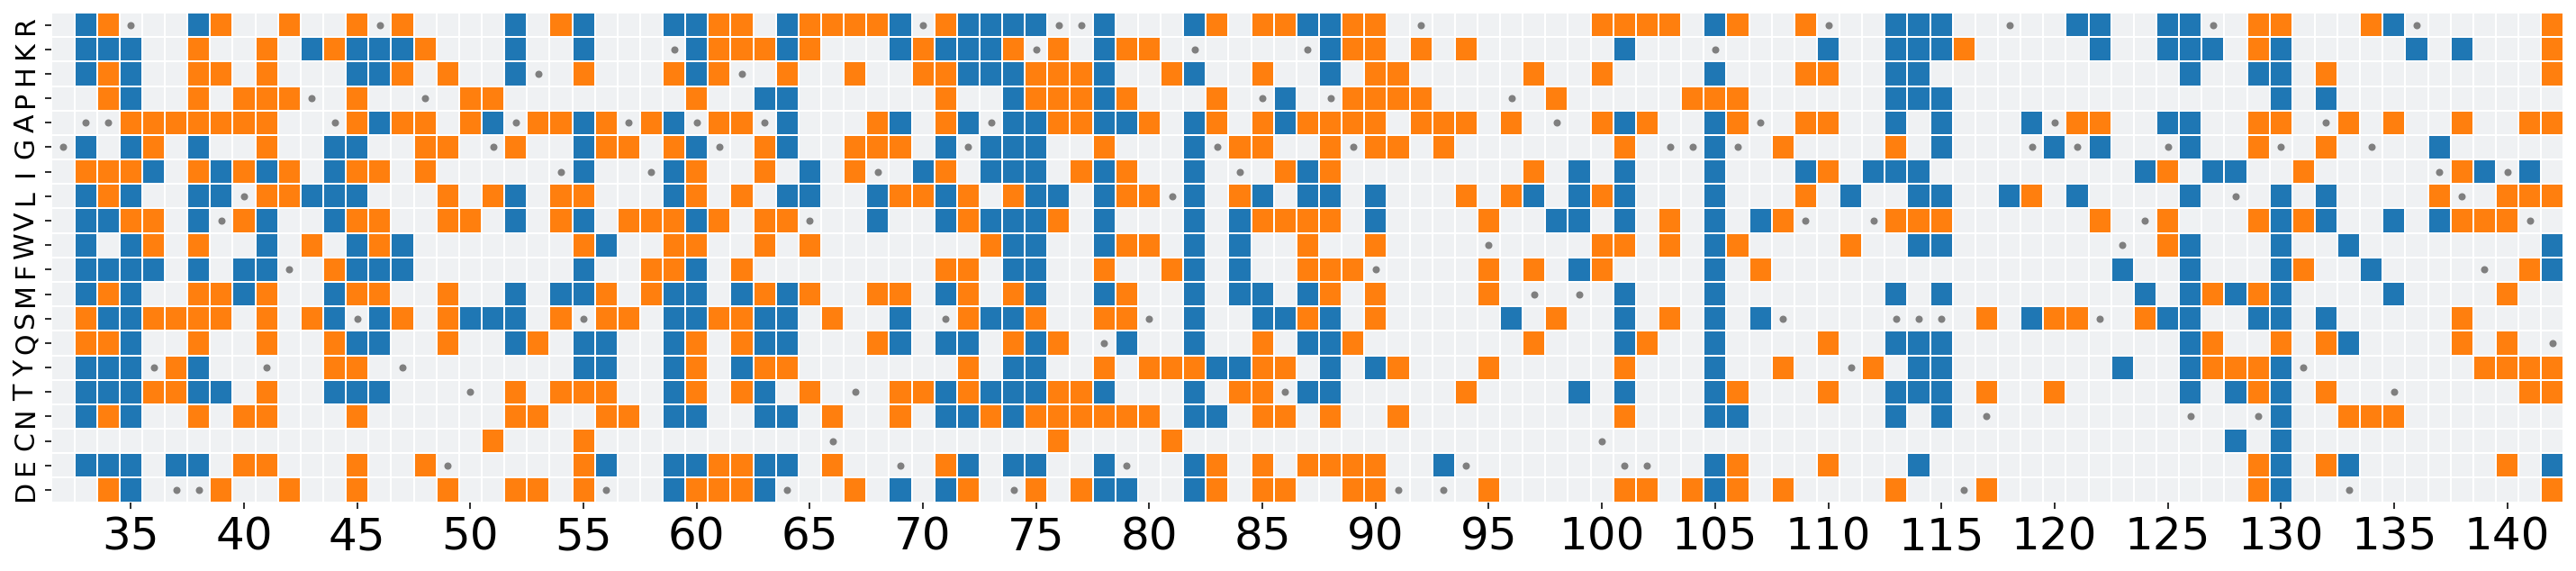

In [ ]:
for i, (name, kwargs) in enumerate(name_to_plot_kwargs.items()):

  fig, ax = plt.subplots(figsize=(25, 5), dpi=500)
  train_df = kwargs['train_df']
  train_df = train_df[train_df['num_mutations'] > 0]

  mutations_a = get_unique_mutations(
      train_df, activity_level=kwargs['activity_level']
  )
  color_a = sns.color_palette()[0]
  mutations_b = get_novel_mutations(**kwargs)
  color_b = sns.color_palette()[1]

  make_mutation_heatmap_comparison(
      mutations_a,
      mutations_b,
      color_a,
      color_b,
      inclusive_one_indexed_position_start=constants.G4_VARIABLE_REGION_START,
      exclusive_one_indexed_position_end=constants.G4_VARIABLE_REGION_END,
      ax=ax,
  )
  ax.yaxis.set_tick_params(labelsize=15)
  ax.xaxis.set_tick_params(labelsize=25)
  plt.xlim(left=constants.G4_VARIABLE_REGION_START, right=constants.G4_VARIABLE_REGION_END)